In [1]:
import sklearn
import sklearn.datasets
from matplotlib import pylab as plt
import numpy as np
from itertools import cycle,islice

In [2]:
import torch
import torchvision
import torchdiffeq

In [31]:
import models
import odenet
import importlib
importlib.reload(models)
importlib.reload(odenet)

<module 'odenet' from '/Users/afq/Google Drive/Colab Notebooks/odenet/odenet.py'>

In [4]:
colors = np.array(list(islice(cycle(
    ['#377eb8', '#ff7f00', '#4daf4a',
     '#f781bf', '#a65628', '#984ea3',
     '#999999', '#e41a1c', '#dede00']),
    int(max([1]) + 1))))

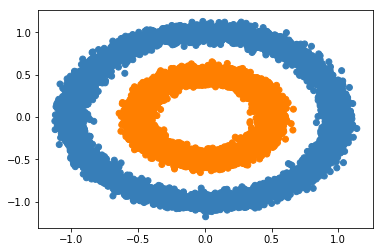

In [5]:
X,Y = sklearn.datasets.make_circles(n_samples=15000, factor=.5,
                                      noise=.05)
plt.scatter(X[:,0],X[:,1],color=colors[Y])

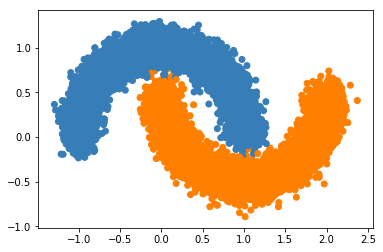

In [6]:
X,Y = sklearn.datasets.make_moons(n_samples=15000,noise=0.1)

plt.scatter(X[:,0],X[:,1],color=colors[Y])

In [7]:
def plot_pred(model):
    pred = torch.sigmoid(model( torch.tensor(X[:1000,:],dtype=torch.float32) ))
    P = pred.detach().numpy()
    P = np.array(np.around(P),dtype=np.int)
    plt.scatter(X[:1000,0],X[:1000,1],color=colors[list(P.flatten())])

In [8]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(X,dtype=torch.float),torch.tensor(Y,dtype=torch.float).reshape(-1,1))
loader = torch.utils.data.DataLoader(dataset,batch_size=64)

In [ ]:
model_deep = models.DeepNet((2,4,4,4,1),Act=torch.nn.LeakyReLU)

In [37]:
import copy

In [131]:
class ODEModel(torch.nn.Module):
    def __init__(self,i_dim,o_dim,ode_width=4,
                 inside_width=4,Act=torch.nn.ReLU,
                method='euler'):
        super(ODEModel,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(i_dim,ode_width),
            odenet.ODEBlock(
                odenet.ShallowODE(1,ode_width,ode_width,act=torch.nn.functional.leaky_relu),
                method='euler'),
            torch.nn.Linear(ode_width,o_dim),
        )
    def forward(self,x):
        # Missing sigmoid
        y = self.net(x)
        return y
    def refine(self):
        new = copy.deepcopy(self)
        new.net[1] = models.refine(self.net[1])
        return new

In [128]:
def train_for_epochs(model, N_epochs, losses = None, lr=1.0e-3):
    if losses is None:
        losses = []
    plot_pred(model)
    plt.show()
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    step_count = 0
    for e in range(N_epochs):
        for imgs,labels in iter(loader):
            #imgs = imgs.reshape(-1,784)
            #print(imgs.shape)
            optimizer.zero_grad()
            #loss = -torch.log()
            out = model(imgs)
            #print(out,labels)
            L = criterion(out,labels)
            L.backward()
            optimizer.step()
            losses.append(L.detach().numpy())
            if step_count % N_print == N_print-1:
                print(L.detach())
                plot_pred(model)
                plt.show()
            step_count += 1
    return losses

In [129]:
def train_adapt(model, N_epochs, N_refine):
    losses = []
    refine_steps = []
    model_list = [model]
    N_print= 10000
    for i in range(N_refine):
        lr =  10.0**(-1-i//2)
        if i > 0:
            model_list.append(model_list[-1].refine())
            print("Adapting to ", models.count_parameters(model_list[-1]), "with lr = ",lr)
        else:
            print("Starting with ",models.count_parameters(model_list[-1]), "with lr = ",lr)
        losses = train_for_epochs(model_list[-1],N_epochs,losses, lr = lr)
        refine_steps.append(len(losses))
    return model_list, losses, refine_steps

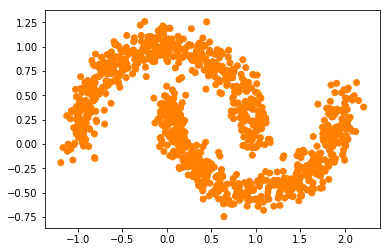

In [124]:
model_shallow = models.ShallowNet(2,1,hidden=8,Act=torch.nn.LeakyReLU)
losses = train_for_epochs(model_shallow, 5, lr = 0.01)

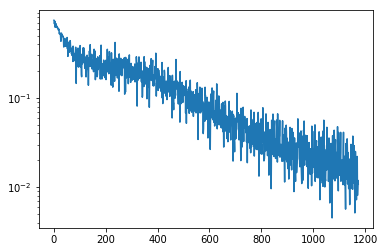

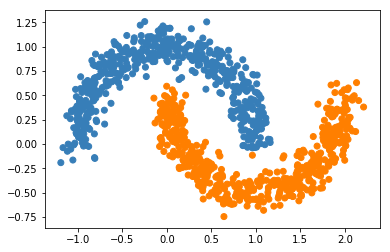

In [125]:
plt.semilogy(losses)
plt.show()
plot_pred(model_shallow)

In [138]:
model = ODEModel(2,1,ode_width=4,inside_width=8,
                 Act=torch.nn.LeakyReLU,method='rk4')

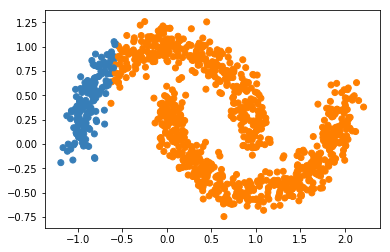

In [139]:
losses = train_for_epochs(model, 5, lr=0.01)

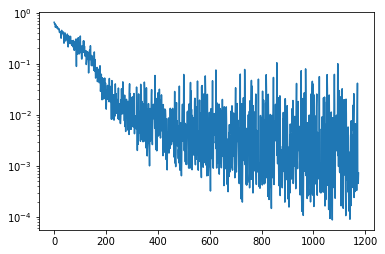

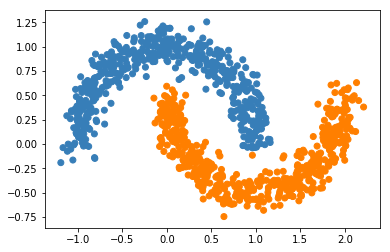

In [140]:
plt.semilogy(losses)
plt.show()
plot_pred(model_shallow)

In [141]:
model_ref = ODEModel(2,1,ode_width=4,inside_width=8,
                 Act=torch.nn.LeakyReLU,method='rk4')

Starting with  57 with lr =  0.1


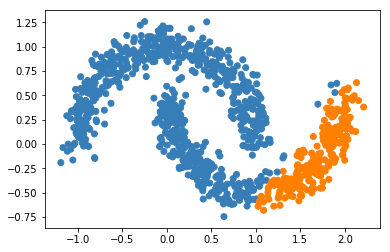

Adapting to  97 with lr =  0.1


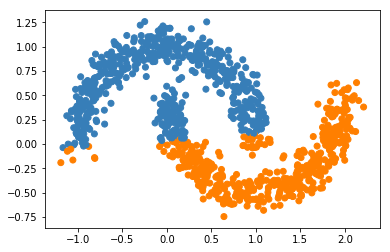

Adapting to  177 with lr =  0.01


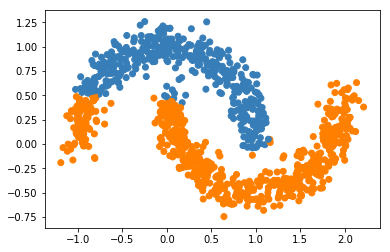

Adapting to  337 with lr =  0.01


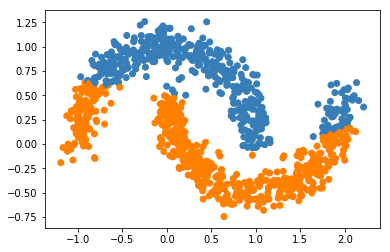

In [143]:
model_list, losses, refine_steps = train_adapt(model_ref,1,4)

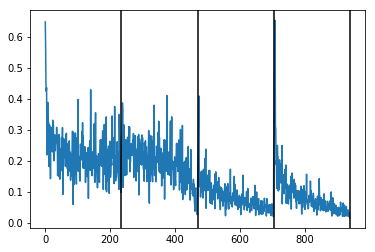

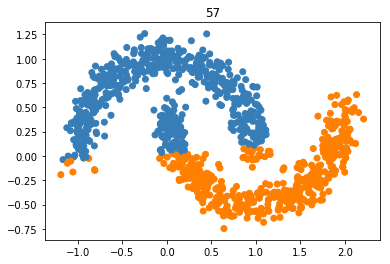

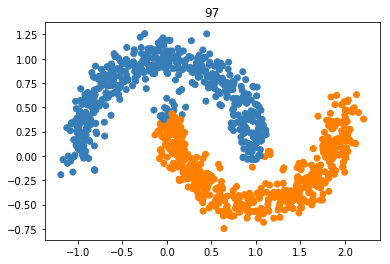

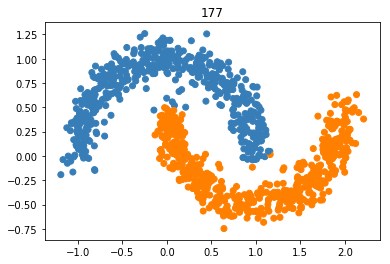

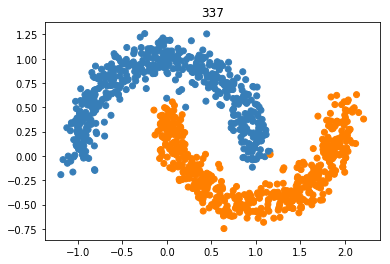

In [144]:
plt.plot(losses)
for r in refine_steps:
    plt.axvline(r,color='k')
plt.show()
for m in model_list:
    plt.title(models.count_parameters(m))
    plot_pred(m)
    plt.show()

In [148]:
def plot_weights_over_time(model_list, grab_it):
    for i,m in enumerate(model_list):
        w = grab_it(m).detach().numpy()
        ts =  m.net[1].ts.detach().numpy()
        #print(ts.shape, w.shape)
        #plt.imshow(w[:,0,:].T)
        plt.subplot(len(model_list),1,i+1)
        dt = ts[1]-ts[0]
        plt.bar(ts[0:-1]+dt*0.5,w,width=ts[1]-ts[0],edgecolor='k')
        plt.xlabel('t')
    plt.show()

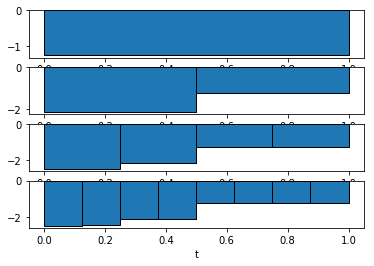

In [151]:
plot_weights_over_time(model_list, lambda x : x.net[1].net.L1.weights[:,0,2])